In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
#Load the awards by director
df_awards_temp = pd.read_csv("mydirectors_name_and_awards.csv", sep=";")
df_awards_temp.drop("tmdbID",axis=1,inplace=True)
df_awards_temp.drop("imdbID",axis=1,inplace=True)
df_awards_temp.drop("queried",axis=1,inplace=True)
df_awards_temp.drop("Unnamed: 0",axis=1,inplace=True)
df_awards_temp["other"]=0

In [3]:
df_awards = pd.DataFrame()
df_awards["name"]=df_awards_temp["name"]
df_awards["total"]=0
df_awards["prestigious"]=0

#Let's keep only the most prestigious awards. 
#Sundance is missing from my data right now though (bug during scraping)
#Filmfare (indian festival) have very low occurence due to indian movies being a very local production
#Also for now we don't use won/nominated columns
prestigious_awards = ["golden lion", "golden globe",  "european film award", "golden berlin bear", "bafta film award", "palme d'or", "oscar"]
for column in df_awards_temp.columns:
    if column!="name" and "won" not in column and "nominated" not in column :
        df_awards["total"]+=df_awards_temp[column]
        if column.lower() in prestigious_awards:
            df_awards[column.lower()]=df_awards_temp[column]
            df_awards["prestigious"]+=df_awards_temp[column]
        

#Drop the directors w/ no prestigious rewards
df_awards.drop(df_awards[df_awards["prestigious"]==0].index, inplace=True)
df_awards.sort_values(by="prestigious", ascending = False,inplace=True) 
df_awards.drop("total", axis=1, inplace=True)
df_awards.drop("prestigious", axis=1, inplace=True)
df_awards.rename(index=str,columns={"name": "director"},inplace=True)
df_awards[:10]

,director,bafta film award,palme d'or,european film award,golden lion,oscar,golden globe,golden berlin bear
972,Woody Allen,15,0,0,0,19,8,1
882,Steven Spielberg,8,1,0,0,12,11,0
457,Joel Coen,8,8,0,0,8,5,1
702,Pedro Almodóvar,10,5,9,1,2,2,1
608,Martin Scorsese,5,4,0,1,9,8,1
774,Robert Altman,4,7,0,3,5,5,3
857,Sidney Lumet,5,4,0,1,5,6,5
91,Billy Wilder,2,0,0,3,14,7,0
298,George Clooney,5,0,0,3,6,10,1
966,Wim Wenders,4,9,5,3,3,0,1


In [4]:
# Chargement du fichier dans un dataframe
df = pd.read_csv("MyMoviesDetailsCastingRaw.csv", sep=";", 
                 parse_dates=["viewing_date", "release_date"], 
                 decimal = ",")
# On remplit les vides avec 0
df = df.fillna("0")

# On convertit les types "objets" en entiers ou décimaux selon
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['vote_average'] = df['vote_average'].astype(float)
df['vote_count'] = df['vote_count'].astype(int)
df['personal_rating'] = df['personal_rating'].astype(int)
df['budget'] = df['budget'].astype(float)
df['revenue'] = df['revenue'].astype(float)
df['runtime'] = df['runtime'].astype(int)
df['production_countries_number'] = df['production_countries_number'].astype(int)
df['production_companies_number'] = df['production_companies_number'].astype(int)
df['actor_number'] = df['actor_number'].astype(int)
df['director_number'] = df['director_number'].astype(int)
df['producer_number'] = df['producer_number'].astype(int)
df['genre_number'] = df['genre_number'].astype(int)

# On multiplie mes notes par 2 pour être homogène à une note sur 10
df['personal_rating'] = df['personal_rating']*2

In [5]:
#On vite les colonnes inutiles & les lignes sans ID tmdb donc inexploitables
df.drop(df[df["tmdb_id"]=="0"].index,inplace=True)
df.drop(df[df["director"]=="0"].index,inplace=True)
df.drop("children",axis=1,inplace=True)
df.drop("tmdb_id",axis=1,inplace=True)
df.drop("original_title",axis=1,inplace=True)
df.drop("viewing_date",axis=1,inplace=True)
df.drop("budget",axis=1,inplace=True)
df.drop("revenue",axis=1,inplace=True)
df.drop("imdb_rating",axis=1,inplace=True)
df.drop("imdb_id",axis=1,inplace=True)
df.drop("production_countries_number",axis=1,inplace=True)
df.drop("production_company",axis=1,inplace=True)
df.drop("production_companies_number",axis=1,inplace=True)
df.drop("director_number",axis=1,inplace=True)
df.drop("producer",axis=1,inplace=True)
df.drop("producer_number",axis=1,inplace=True)
df['release_year'] = pd.DatetimeIndex(df['release_date']).year
df.drop("release_date",axis=1,inplace=True)


#On remplace les notes TMDB nulles par la moyenne = 6.84 (<10% des films sont concernés)
df.loc[df["vote_average"]==0,"vote_average"] = 6.8

#On ajoute en attribut le nb de films vus du même directeur (leakage ?)
df2 = df.groupby("director",as_index=False).count().loc[:,["director","title"]]
df2.rename(columns = {'title':'movies_same_director_watched'}, inplace = True)
df=pd.merge(df,df2,on="director")

In [6]:
#let's add rewards
df=pd.merge(df,df_awards,on="director")
df[:5]

,title,personal_rating,original_language,vote_count,vote_average,runtime,production_country,genre,genre_number,director,actor_number,release_year,movies_same_director_watched,bafta film award,palme d'or,european film award,golden lion,oscar,golden globe,golden berlin bear
0,The face of another,6,ja,44,7.5,124,Japan,Drama,2,Hiroshi Teshigahara,10,1966,2,0,1,0,0,1,0,0
1,La femme des sables,10,ja,78,8.1,147,Japan,Drama,2,Hiroshi Teshigahara,6,1964,2,0,1,0,0,1,0,0
2,Into the inferno,6,en,38,7.0,104,Canada,Documentary,1,Werner Herzog,8,2016,20,1,4,1,2,1,0,3
3,"Lo and Behold, Reveries of the Connected World",6,en,69,6.5,98,United States of America,Documentary,1,Werner Herzog,4,2016,20,1,4,1,2,1,0,3
4,Lessons of Darkness,8,de,25,8.3,54,United Kingdom,War,2,Werner Herzog,1,1992,20,1,4,1,2,1,0,3


# Premier essai : ma note binaire ("liked")

In [7]:
#On binarise ma note >5 = j'ai aimé, sinon non
df["liked"]=0
df.loc[df["personal_rating"]>5,"liked"]=1

In [8]:
#Fonction qui permet de mesurer l'importance de la feature dans le fait que j'aime un film ou pas (en %)
def compare(feature,df):
    return df.groupby(feature)["liked"].sum()*100/df.groupby(feature)["liked"].count()

#Fonction pour encoder les features catégorielles (on crée une colonne avec le suffixe_code)
def encode(feature,df) :
    df[feature] = pd.Categorical(df[feature])
    df[feature+"_code"] = df[feature].cat.codes
    return df

In [9]:
#On encore les features de type "catégories"
df = encode("original_language",df)
df = encode("production_country",df)
df = encode("genre",df)

In [10]:
#On splitte le dataset en 2 dataset : 80% pour entrainer le modele, 20% pour le test
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2)

In [11]:
df

,title,personal_rating,original_language,vote_count,vote_average,runtime,production_country,genre,genre_number,director,...,palme d'or,european film award,golden lion,oscar,golden globe,golden berlin bear,liked,original_language_code,production_country_code,genre_code
0,The face of another,6,ja,44,7.5,124,Japan,Drama,2,Hiroshi Teshigahara,...,1,0,0,1,0,0,1,15,23,6
1,La femme des sables,10,ja,78,8.1,147,Japan,Drama,2,Hiroshi Teshigahara,...,1,0,0,1,0,0,1,15,23,6
2,Into the inferno,6,en,38,7.0,104,Canada,Documentary,1,Werner Herzog,...,4,1,2,1,0,3,1,7,7,5
3,"Lo and Behold, Reveries of the Connected World",6,en,69,6.5,98,United States of America,Documentary,1,Werner Herzog,...,4,1,2,1,0,3,1,7,43,5
4,Lessons of Darkness,8,de,25,8.3,54,United Kingdom,War,2,Werner Herzog,...,4,1,2,1,0,3,1,5,42,17
5,Little Dieter Needs To Fly,8,en,24,7.9,80,France,Documentary,1,Werner Herzog,...,4,1,2,1,0,3,1,7,13,5
6,Woyzeck,4,de,38,6.5,82,Germany,Drama,1,Werner Herzog,...,4,1,2,1,0,3,0,5,14,6
7,Even dwarfs started small,4,de,26,6.6,96,Germany,Comedy,2,Werner Herzog,...,4,1,2,1,0,3,0,5,14,3
8,Into the abyss,6,en,72,7.1,105,United States of America,Documentary,2,Werner Herzog,...,4,1,2,1,0,3,1,7,43,5
9,Where the green ants dream,4,de,10,7.1,100,Australia,Drama,1,Werner Herzog,...,4,1,2,1,0,3,0,5,3,6


In [12]:
#On entraine l'arbre
from sklearn.tree import DecisionTreeClassifier
features = ['vote_count','vote_average', 'release_year', 'production_country_code','movies_same_director_watched','original_language_code','genre_code']
features = features + prestigious_awards
result="liked"


#On teste le score avec plusieurs noeuds
score=pd.DataFrame(columns=["leaf_nodes","score"])

for i in range(3,100):
    clf = DecisionTreeClassifier(max_leaf_nodes=i)
    clf = clf.fit(train[features],train[result])
    #On teste l'accuracy du modèle
    predictions = clf.predict(test[features])
    from sklearn.metrics import accuracy_score
    score.loc[i,"leaf_node"]=i
    score.loc[i,"score"]=accuracy_score(test[result],predictions)



# View a list of the features and their importance scores
list(zip(train[features], clf.feature_importances_))
    

[('vote_count', 0.21312980406267057),
 ('vote_average', 0.19736053385568672),
 ('release_year', 0.12802977763899412),
 ('production_country_code', 0.032145098236849051),
 ('movies_same_director_watched', 0.058046439885864595),
 ('original_language_code', 0.031432997546724538),
 ('genre_code', 0.058538144553512098),
 ('golden lion', 0.021145524813714213),
 ('golden globe', 0.073203403510591403),
 ('european film award', 0.039657695371159901),
 ('golden berlin bear', 0.038221410325564677),
 ('bafta film award', 0.048091037975984456),
 ("palme d'or", 0.037908445057913659),
 ('oscar', 0.023089687164769897)]

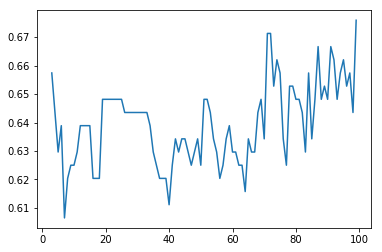

In [13]:
import matplotlib.pyplot as plt
plt.plot(score["leaf_node"],score["score"])
plt.show()

In [14]:
#Affichage de l'arbre
from sklearn import tree
with open("classify.dot","w") as f:
    f=tree.export_graphviz(clf,feature_names=features,out_file=f)
#installer ensuite le programme GRAPHVIZ et ouvrir le fichier classify.dot avec le programme gvedit.exe

In [15]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
# Create a random forest Classifier
for i in range(98,99):
    clf = RandomForestClassifier(n_jobs=2, random_state=i,max_leaf_nodes=22)
    # Train the Classifier to take the training features
    clf.fit(train[features], train[result])
    # Apply the Classifier we trained to the test data (which, remember, it has never seen before)
    clf.predict(test[features])
    # View the predicted probabilities of the first 10 observations
    clf.predict_proba(test[features])[0:10]
    #On teste l'accuracy du modèle
    predictions = clf.predict(test[features])
    print("i="+str(i)+";"+str(accuracy_score(test[result],predictions)))

i=98;0.652777777778


In [16]:
#lets show confusion matrix
from sklearn.metrics import confusion_matrix
y_actu = test[result]
y_pred = clf.predict(test[features])
confusion_matrix(y_actu, y_pred)

array([[ 23,  52],
       [ 23, 118]])

In [17]:
#ROC curve
from sklearn import metrics
import matplotlib.pyplot as plt

preds = clf.predict_proba(test[features])[:,1]
fpr, tpr, _ = metrics.roc_curve(test[result], preds)


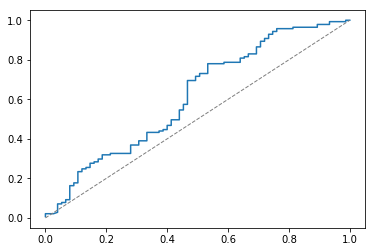

In [18]:
#ROC curve vs random guess => not really great
plt.plot(fpr,tpr)
plt.plot([0,1], 'k--', lw=1,color="grey")
plt.show()

In [24]:
#let's try logistic regression as my score (liked / not liked) is categorial
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()
model2.fit(train[features], train[result])
predicted = model2.predict(test[features])

# generate evaluation metrics
print (metrics.accuracy_score(test[result], predicted))

0.680555555556


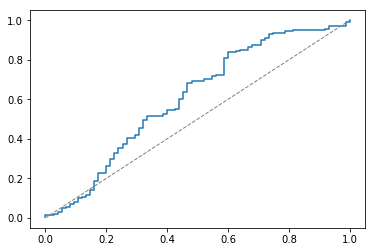

In [23]:
preds = model2.predict_proba(test[features])[:,1]
fpr, tpr, _ = metrics.roc_curve(test[result], preds)
plt.plot(fpr,tpr)
plt.plot([0,1], 'k--', lw=1,color="grey")
plt.show()

In [28]:
#let's try multinomial logistic regression
result="personal_rating"
model3 = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model3.fit(train[features], train[result])
predicted = model3.predict(test[features])

# generate evaluation metrics
print (metrics.accuracy_score(test[result], predicted))
preds = model3.predict_proba(test[features])[:,1]
fpr, tpr, _ = metrics.roc_curve(test[result], preds)
plt.plot(fpr,tpr)
plt.plot([0,1], 'k--', lw=1,color="grey")
plt.show()

C:\Users\rapno\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\rapno\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


0.314814814815


C:\Users\rapno\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


ValueError: Data is not binary and pos_label is not specified

In [ ]:
#ça ne converge pas